In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Import the data to Train and Test dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(4209, 378)
(4209, 377)


In [3]:
train_df.sample(5)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
1182,2353,108.12,w,v,t,d,d,ab,h,c,...,0,1,0,0,0,0,0,0,0,0
1522,3036,76.80,az,v,n,f,d,ad,g,j,...,0,0,0,1,0,0,0,0,0,0
266,528,76.64,az,v,as,f,d,i,g,n,...,0,0,0,1,0,0,0,0,0,0
3489,6962,96.56,y,f,f,c,d,r,g,q,...,0,0,1,0,0,0,0,0,0,0
166,348,98.25,z,v,a,b,d,i,j,o,...,1,0,0,0,0,0,0,0,0,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [5]:
#we could see there are 8 features which are object types (need to apply encoding)
#write a function to get the list of all features which are object types

for i in train_df.columns:
    data_type = train_df[i].dtype
    if data_type == 'object':
        print(i)

X0
X1
X2
X3
X4
X5
X6
X8


## If for any column(s), the variance is equal to zero, then you need to remove those variable(s).

In [6]:
variance = pow(train_df.drop(columns=['ID','y']).std(),2).to_dict()

null_count = 0
for key, value in variance.items():
    if(value==0):
        print('Name = ',key)
        null_count+=1
print('No of columns which has zero variance = ',null_count)

Name =  X11
Name =  X93
Name =  X107
Name =  X233
Name =  X235
Name =  X268
Name =  X289
Name =  X290
Name =  X293
Name =  X297
Name =  X330
Name =  X347
No of columns which has zero variance =  12


In [7]:
#droping the columns which has 0 variance
train_df = train_df.drop(columns=['X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347'])
train_df.shape

(4209, 366)

## Check for null and unique values for test and train sets

In [8]:
train_df.isnull().sum().any()

False

## Apply label encoder

In [9]:
le = LabelEncoder()

In [10]:
X_train_df = train_df.drop(columns=['ID','y'])
y_train_df = train_df.y
print(X_train_df.shape)
print(y_train_df.shape)


(4209, 364)
(4209,)


In [11]:
X_train_df.describe(include='O')

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,w,g,j
freq,360,833,1659,1942,4205,231,1042,277


In [12]:
X_train_df['X0'] = le.fit_transform(X_train_df.X0)
X_train_df['X1'] = le.fit_transform(X_train_df.X1)
X_train_df['X2'] = le.fit_transform(X_train_df.X2)
X_train_df['X3'] = le.fit_transform(X_train_df.X3)
X_train_df['X4'] = le.fit_transform(X_train_df.X4)
X_train_df['X5'] = le.fit_transform(X_train_df.X5)
X_train_df['X6'] = le.fit_transform(X_train_df.X6)
X_train_df['X8'] = le.fit_transform(X_train_df.X8)

## Perform dimensionality reduction.

In [13]:
print(X_train_df.shape)
print(y_train_df.shape)

(4209, 364)
(4209,)


In [14]:
pca = PCA(n_components=.95)

#pca.fit(X_train_df, y_train_df)
pca.fit(X_train_df)

PCA(n_components=0.95)

In [15]:
X_train_transformed = pca.transform(X_train_df)
print(X_train_transformed.shape)

(4209, 6)


## Predict test_df values using XGBoost

In [17]:
#split the data into train and test split
X_train,X_test,y_train,y_test = train_test_split(X_train_transformed,y_train_df,test_size=.3,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2946, 6)
(1263, 6)
(2946,)
(1263,)


## XGBoost's hyperparameters tuning manually

In [32]:
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.4, max_depth = 10, alpha = 6, 
                           n_estimators = 20)
model = xgb_reg.fit(X_train,y_train)
print('RMSE = ',sqrt(mean_squared_error(model.predict(X_test),y_test)))

[00:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE =  12.378736012513533


After tuning the hyperparameters to meet minimum RMSE, RMSE turned out as 12.37

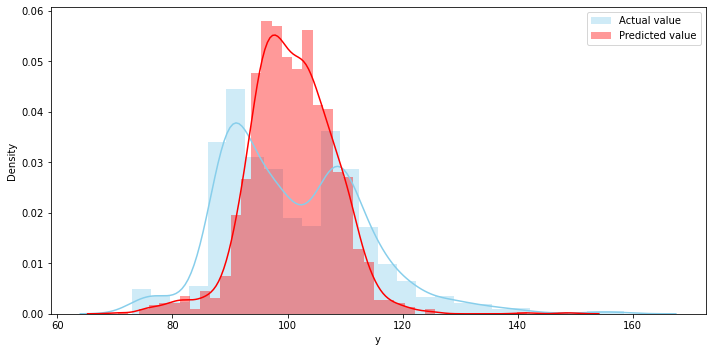

In [19]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10,5))

sns.distplot(y_test[y_test<160], color="skyblue", label="Actual value")
sns.distplot(y_pred[y_pred<160] , color="red", label="Predicted value")
plt.legend()

plt.tight_layout()


## Prediction on test data set using XGBoost

In [20]:
#Preparing testing dataset
test_df = test_df.drop(columns={'X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347'})
test_df.shape

(4209, 365)

In [21]:
test_df.isnull().sum().any()

False

In [22]:
test_data_feature = test_df.drop(columns={'ID'})
print(test_data_feature.shape)

(4209, 364)


In [23]:
test_data_feature.describe(include='object')

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,49,27,45,7,4,32,12,25
top,ak,aa,as,c,d,v,g,e
freq,432,826,1658,1900,4203,246,1073,274


In [24]:
test_data_feature['X0'] = le.fit_transform(test_data_feature.X0)
test_data_feature['X1'] = le.fit_transform(test_data_feature.X1)
test_data_feature['X2'] = le.fit_transform(test_data_feature.X2)
test_data_feature['X3'] = le.fit_transform(test_data_feature.X3)
test_data_feature['X4'] = le.fit_transform(test_data_feature.X4)
test_data_feature['X5'] = le.fit_transform(test_data_feature.X5)
test_data_feature['X6'] = le.fit_transform(test_data_feature.X6)
test_data_feature['X8'] = le.fit_transform(test_data_feature.X8)

In [25]:
pca.fit(test_data_feature)

PCA(n_components=0.95)

In [26]:
test_data_feature_trans = pca.transform(test_data_feature)
print(test_data_feature_trans.shape)

(4209, 6)


In [27]:
test_pred = model.predict(test_data_feature_trans)
test_pred

array([ 91.30857 ,  92.74863 ,  96.62054 , ...,  91.309235, 115.794624,
       104.09888 ], dtype=float32)

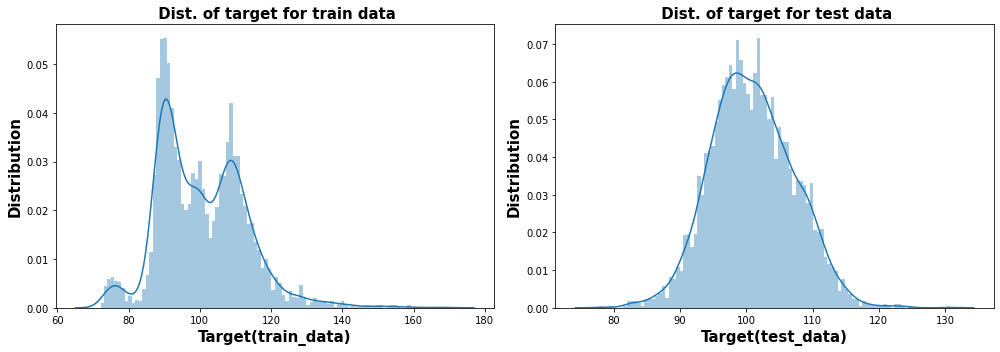

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

train_plot = sns.distplot(y_train_df[y_train_df<200], bins=100, kde=True, ax=ax[0])
train_plot.set_xlabel('Target(train_data)', weight='bold', size=15)
train_plot.set_ylabel('Distribution', weight='bold', size=15)
train_plot.set_title(' Dist. of target for train data', weight='bold', size=15)

test_plot = sns.distplot(test_pred[test_pred<200], bins=100, kde=True, ax=ax[1])
test_plot.set_xlabel('Target(test_data)', weight='bold', size=15)
test_plot.set_ylabel('Distribution', weight='bold', size=15)
test_plot.set_title(' Dist. of target for test data', weight='bold', size=15)

plt.tight_layout()